# This notebook shows how to download and read the prepared CelebA face dataset.

This dataset is prepared for the pairwise synthetic face data generation tasks. In particular, we
- detected human faces in the original celebA (not the HQ version)
- aligned each detected face with the maximum allowed size, upscale an image if its size is below 256x via GFPGAN, see folder `images/`
- restore image via the CodeFormer, see folder `images_v2/`
- derived the mediapipe 468 face landmarks with confidence, see folder `landmarks/`
- used the landmarks to synthesize a 11-class face mask, see folder `masks/`
- dumped corresponding x,y,z(depth) map according to the 468-3D landmarks, see folder `xyzmaps/`
- generated captions for each image using BLIP/SwinVit models, see folder `captions/`
- extracted face features for each image via arcface, see folder `feat_file_v2/`
- predicted microsoft 19-class face semantic mask from an in-house model, see folder `msmasks/`
- estimated facial attributes including age, gender, and emotions via an in-house model, see folder `attributes/`

All above files are saved in a single dataset file `celebaFacesDataset256+.csv`. 
| header | Description | Example | Comments| 
|---:|---:|-----:|-----:|
|face_file| relative file path a face image| CelebAFaces/8843/images/111082.jpg | already cropped and aligned image of size NxNx3 |
|aligned_size| size of `face_file` | 384 | should be an integer greater than 256, i.e. N|
|src_nose_xy| nose absolute (x,y) coords in the original image | "[192.0, 161.0]"| *load via `json.loads()`|
|bbox| the normalized face bbox of (left, top, right, bottom) | "[0.16, 0.23, 0.80, 0.86]"| **load via `json.loads()`|
|subject_id| subject id | 234 | an integer in between 1 and 10177 | 
|attributes| facial attributes copied from celebA annotations | "[""Arched Eyebrows"", ""Attractive"", ""Blond Hair"", ""Female""]" | **load via `json.loads()`| 
|landmark_file| mediapipe 468 2d-landmark | CelebAFaces/8843/landmarks/111082.csv | no header .csv, format of (x, y) |
|label_uncertainty| the estimated landmark prediction uncertainty| 0.0039210257430871 | a positive float, smaller is better |
|mask_file|  mediapiple 11-class face mask | CelebAFaces/8843/masks/111082.png | pseudo-RGB of size MxMx3 |
|xyz_file|  x,y,and z face mesh maps |CelebAFaces/8843/xyzmaps/111082.npy| numpy array of size MxMx3|
|depth_range| absolute face depth map's min and max| "[-0.1393761932849884, 0.35237544775009155]" | load via `json.loads()`
|annot_size| annotation size for all derived files |256 | always be 256 in this dataset, i.e, M=256|
|caption_file| BLIP/SwinViT captions for the face images|CelebAFaces/8843/captions/111082.json| a dict of `{"caption": {"model_name": "BLIP", "CLIP_simi": 0.3}`|
|attr_file| facial attributes like age, gender, emotions, etc.| CelebAFaces/8843/attributes/111082.json | a dict of attributes |
|msmask_file| microsoft 19-class semantic face mask | CelebAFaces/8843/msmasks/111082.png| pseudo-RGB of size MxMx3 | 
|msmask_score| microsoft mask score | 0.95| a float in (0,1), higher is better |
|feat_file | arcface 512-d feature | CelebAFaces/8843/feats/111082.json | load via `json.loads()`|


- author: Dense-Face
- date: 07/19/2023

In [31]:
%matplotlib inline
from matplotlib import pyplot
import cv2
import json
import pandas as pd
import numpy as np 
from PIL import Image

In [32]:
import os
root_dir = './CelebA/'
df = pd.read_csv(os.path.join(root_dir, 'celebaFacesDataset256+.csv'))


In [33]:
# collect samples w.r.t. subject_id
subj2indices = {}
for i, subj in enumerate(df['subject_id']) :
    if subj not in subj2indices :
        subj2indices[subj] = []
    subj2indices[subj].append(i)

In [34]:
prng = np.random.RandomState(54321)
subj = prng.choice(list(subj2indices.keys()))
num_samples = 6

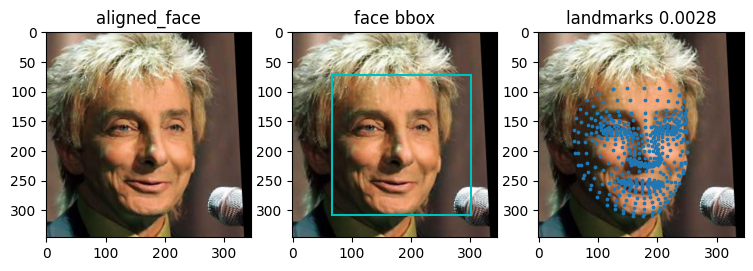

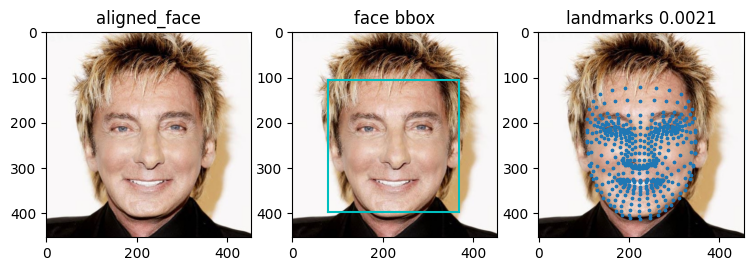

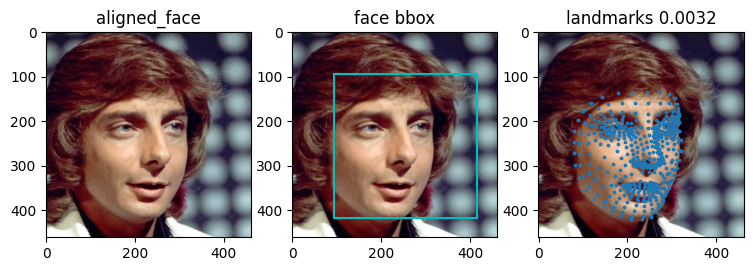

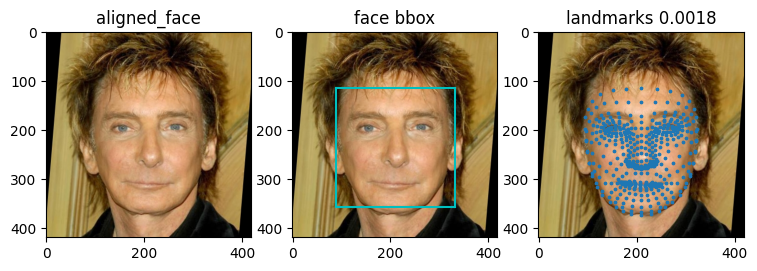

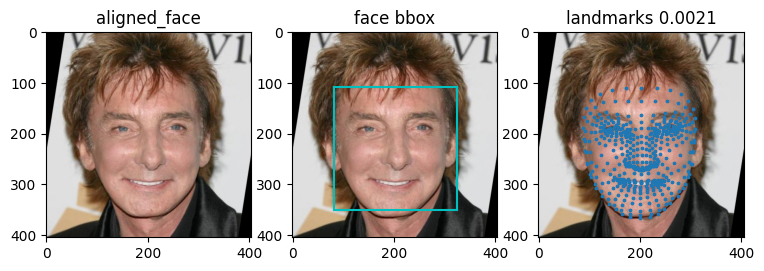

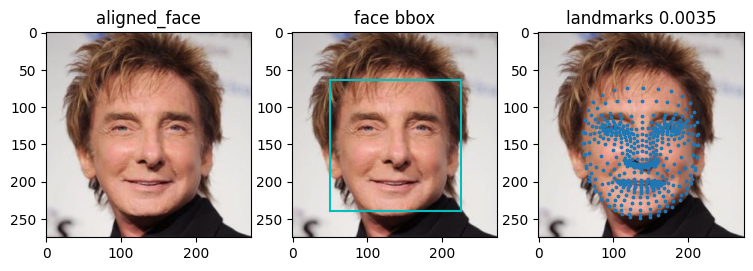

In [35]:
# 1. show face image + bbox + landmarks
def show_img_bbox_landmarks(sample) :
    # read face_file
    img = Image.open(os.path.join(root_dir, sample['face_file']))
    # read face bbox 
    bbox = json.loads(sample['bbox'])
    size = sample['aligned_size']
    # read landmarks
    landmarks = pd.read_csv(os.path.join(root_dir, sample['landmark_file']), header=None).to_numpy()
    uncertainty = sample['label_uncertainty']
    # denormalize bbox
    left, top, right, bottom = [v * size for v in bbox]
    landmarks *= size

    pyplot.figure(figsize=(3 * 3, 3))
    pyplot.subplot(1,3,1)
    pyplot.imshow(img)
    pyplot.title('aligned_face')

    pyplot.subplot(1,3,2)
    pyplot.imshow(img)
    pyplot.plot([left, left], [top, bottom], c='c')
    pyplot.plot([right, right], [top, bottom], c='c')
    pyplot.plot([left, right], [top, top], c='c')
    pyplot.plot([left, right], [bottom, bottom], c='c')
    pyplot.title('face bbox')

    pyplot.subplot(1,3,3)
    pyplot.imshow(img)
    pyplot.scatter(landmarks[:,0], landmarks[:,1], s=3)
    pyplot.title(f'landmarks {uncertainty:.4f}')
    pyplot.show()
    return

for i in subj2indices[subj][:num_samples] :
    sample= df.iloc[i]
    show_img_bbox_landmarks(sample)



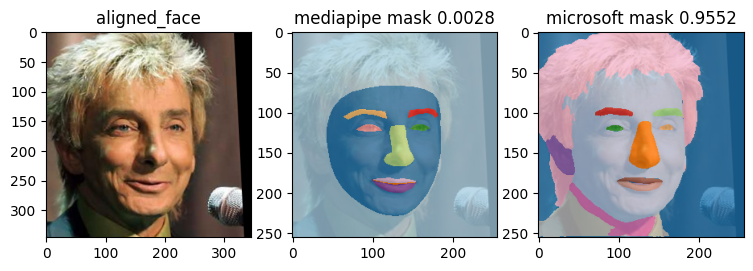

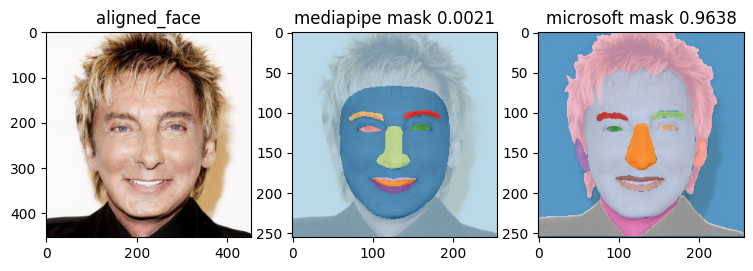

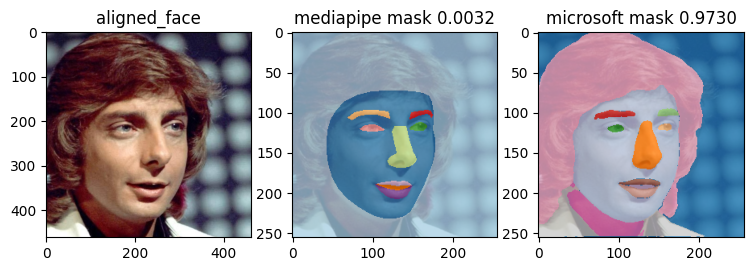

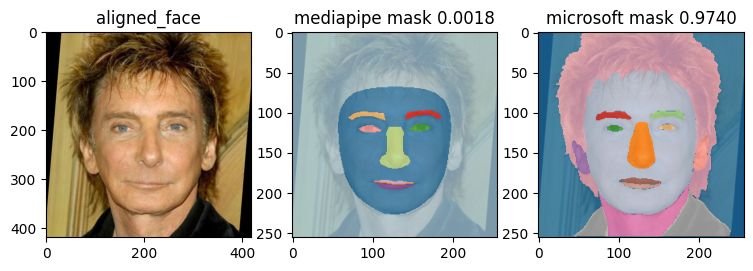

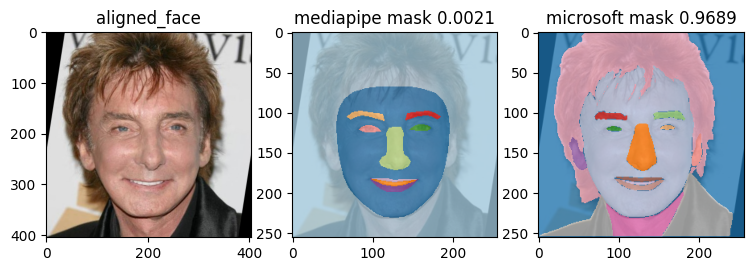

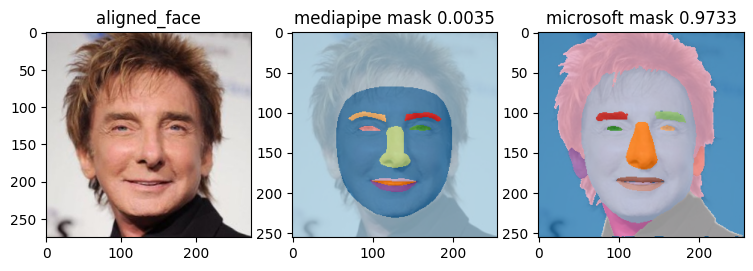

In [36]:
# 2. show face image + mask + msmask
def show_img_mask_msmask(sample) :
    # read face_file
    img = Image.open(os.path.join(root_dir, sample['face_file']))
    size = sample['annot_size']
    annot = img.resize((size, size))
    # read mask
    uncertainty = sample['label_uncertainty']
    mask = Image.open(os.path.join(root_dir, sample['mask_file']))
    # read msmask
    msmask = Image.open(os.path.join(root_dir, sample['msmask_file']))
    score = sample['msmask_score']

    pyplot.figure(figsize=(3 * 3, 3))
    pyplot.subplot(1,3,1)
    pyplot.imshow(img)
    pyplot.title('aligned_face')

    pyplot.subplot(1,3,2)
    pyplot.imshow(annot)
    pyplot.imshow(mask, alpha=0.75)
    pyplot.title(f'mediapipe mask {uncertainty:.4f}')

    pyplot.subplot(1,3,3)
    pyplot.imshow(annot)
    pyplot.imshow(msmask, alpha=0.75)
    pyplot.title(f'microsoft mask {score:.4f}')
    
    pyplot.show()
    return

for i in subj2indices[subj][:num_samples] :
    sample= df.iloc[i]
    show_img_mask_msmask(sample)



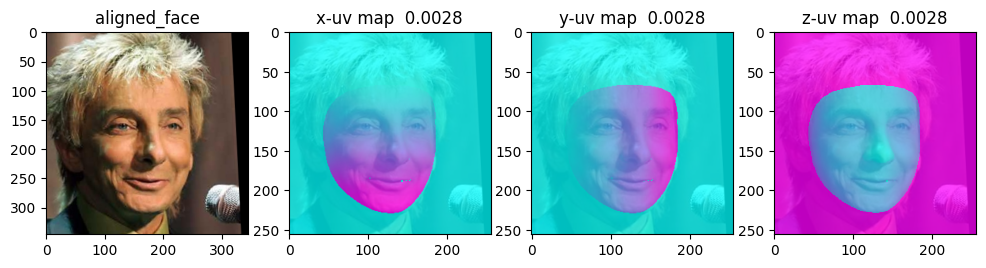

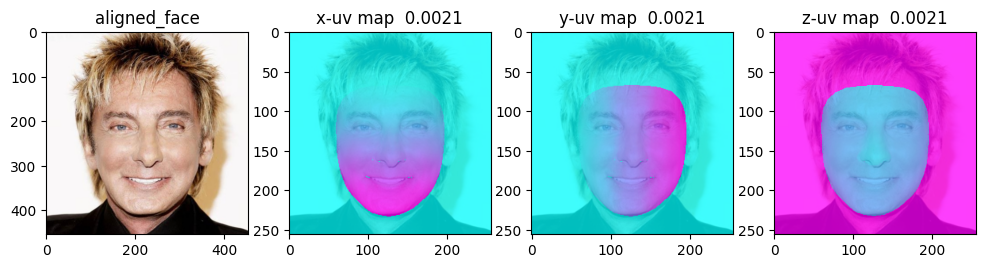

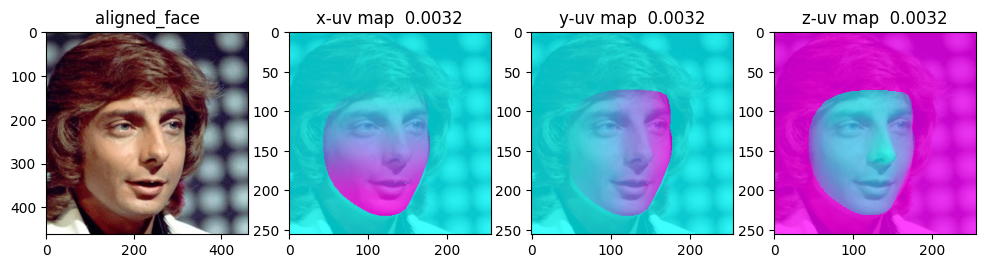

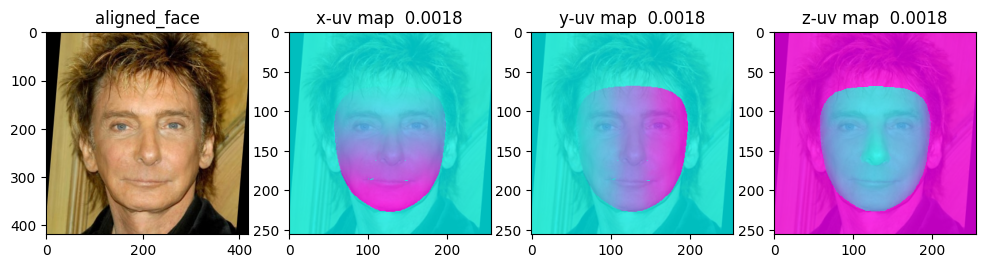

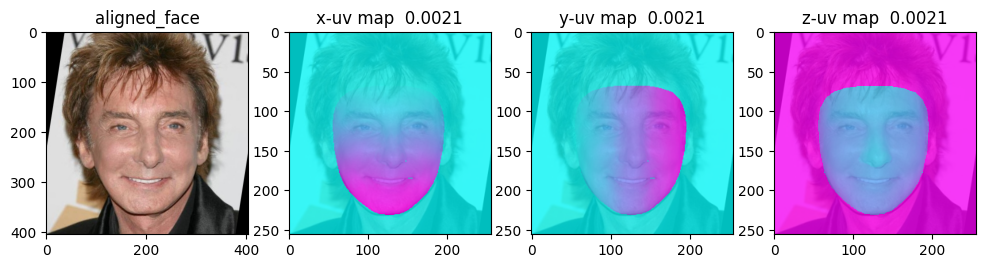

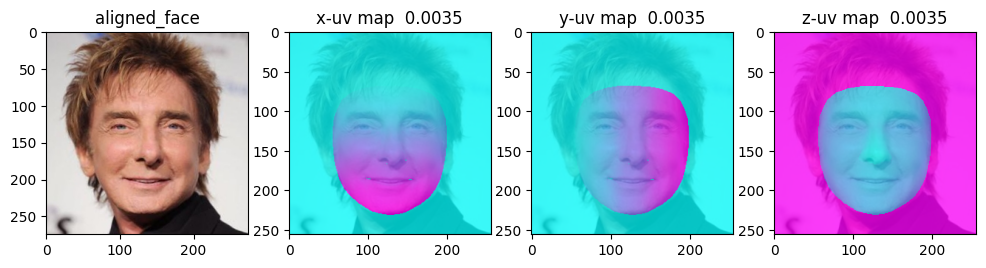

In [37]:
# 3. show face image + xyz maps
def show_img_xyzmaps(sample) :
    # read face_file
    img = Image.open(os.path.join(root_dir, sample['face_file']))
    size = sample['annot_size']
    annot = img.resize((size, size))
    # read mask
    uncertainty = sample['label_uncertainty']
    xyzmaps = np.load(os.path.join(root_dir, sample['xyz_file']))
    xmap, ymap, depth = np.split(xyzmaps, 3, axis=-1)
    dmin, dmax = json.loads(sample['depth_range'])

    pyplot.figure(figsize=(3 * 4, 3))
    pyplot.subplot(1,4,1)
    pyplot.imshow(img)
    pyplot.title('aligned_face')

    pyplot.subplot(1,4,2)
    pyplot.imshow(annot)
    pyplot.imshow(xmap, vmin=-1, vmax=62, cmap='cool', alpha=0.75)
    pyplot.title(f'x-uv map  {uncertainty:.4f}')

    pyplot.subplot(1,4,3)
    pyplot.imshow(annot)
    pyplot.imshow(ymap, vmin=-1, vmax=62, cmap='cool', alpha=0.75)
    pyplot.title(f'y-uv map  {uncertainty:.4f}')

    pyplot.subplot(1,4,4)
    pyplot.imshow(annot)
    pyplot.imshow(depth, vmin=dmin, vmax=dmax, cmap='cool', alpha=0.75)
    pyplot.title(f'z-uv map  {uncertainty:.4f}')
    
    pyplot.show()
    return

for i in subj2indices[subj][:num_samples] :
    sample= df.iloc[i]
    show_img_xyzmaps(sample)



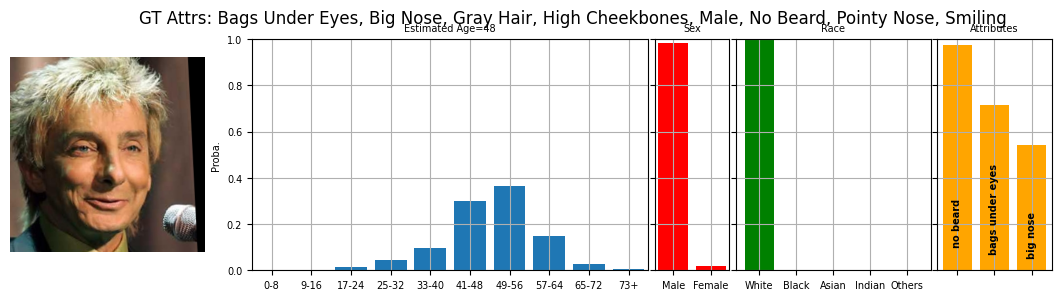

blip2-2.7b(0.2914): rod stewart's son, robert stewart, dies at age 33
blip-base(0.2841): rod rod, rod, rod, rod, rod, rod rod rod rod rod rod rod rod rod rod
blip2-flan-t5-xl(0.2810): a man with blonde hair and a microphone
blip-large(0.2647): arafed man with a microphone and a suit smiling at the camera
vit-swin(0.2460): A man in a suit and tie with a microphone.
vit-gpt2(0.2217): a man in a suit and tie
git-large-coco(0.1852): [ unused0 ] is listed ( or ranked ) 3 on the list [ unused0 ]


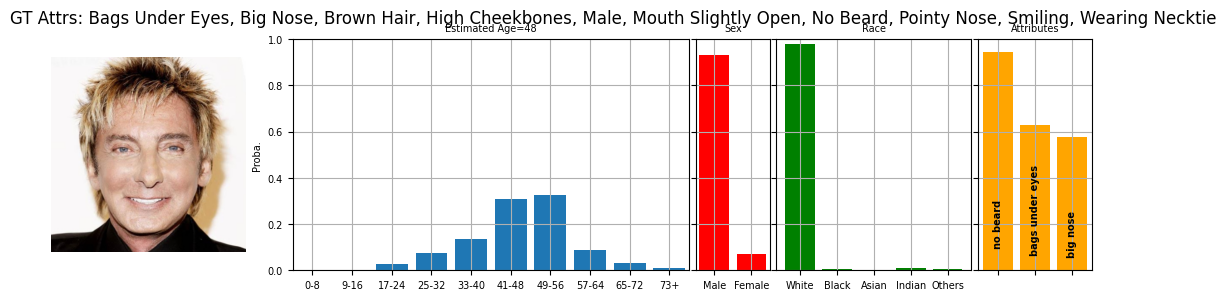

blip2-2.7b(0.3430): barry manilow's hair is a mess
blip-base(0.2850): rod rod rod rod rod rod rod rod rod rod rod rod rod rod rod rod rod rod rod rod rod
blip2-flan-t5-xl(0.2616): a man with short hair smiling for the camera
blip-large(0.2551): a close up of a man with a very short haircut
git-large-coco(0.2364): ##0 ] is a singer, songwriter, musician, and musician. he is best known for playing [ unused0 ] in the [ unused0 ]. [ unused0 ], [ unused0
vit-swin(0.1908): A man with a beard and a tie.
vit-gpt2(0.1800): a man with a beard and a mustache


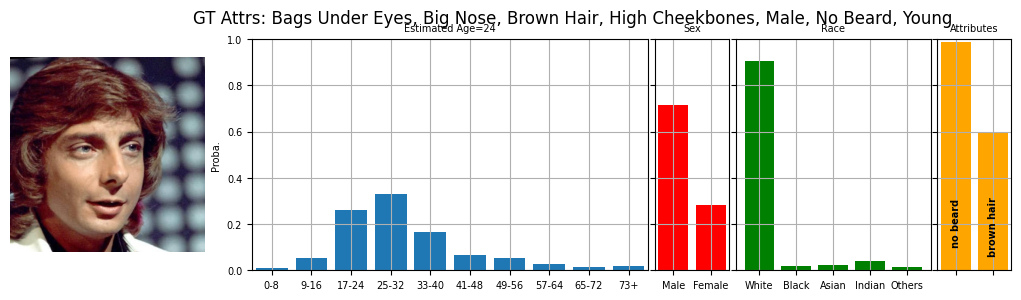

blip2-2.7b(0.2694): a man with long hair wearing a white jacket
blip2-flan-t5-xl(0.2692): a man with long hair and a white jacket
blip-base(0.2570): a man with long hair and a white shirt
blip-large(0.2268): a close up of a man with a tie and a suit
vit-gpt2(0.2185): a man in a suit and tie
git-large-coco(0.2166): ##0 ], the voice of [ unused0 ], [ unused0 ], [ unused0 ], [ unused0 ], [ unused0 ], [ unused0 ], [ unused
vit-swin(0.1937): A man with a beard and a tie.


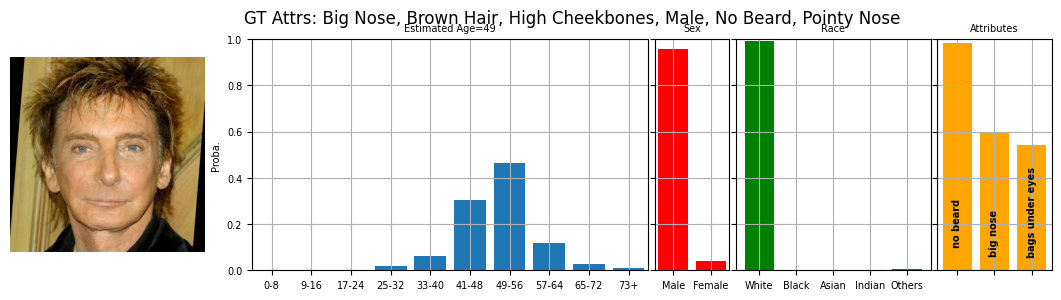

blip2-flan-t5-xl(0.2795): a man with blue eyes and a black jacket
blip-base(0.2694): rod rod rod rod rod rod rod rod rod rod rod rod rod rod rod rod rod rod rod rod rod
git-large-coco(0.2571): ##0 ] is a singer, songwriter, and musician. he is best known for his role as [ unused0 ] in the rock and roll band. [ unused0 ], [ unused0
blip-large(0.2513): a close up of a man with a very short haircut
blip2-2.7b(0.2450): a close up of a man with blue eyes
vit-gpt2(0.1998): a man with a beard and a tie
vit-swin(0.1975): A man with a beard and a tie.


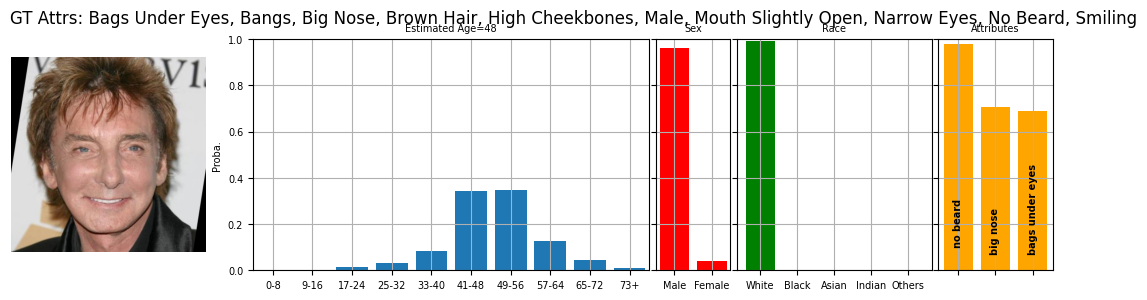

blip2-2.7b(0.3445): barry manilow to perform at the grammys
blip-base(0.2775): rod vandy, who is the most known person in the world
blip-large(0.2670): a close up of a man with a black jacket and a black shirt
blip2-flan-t5-xl(0.2546): a man with short hair smiling for the camera
git-large-coco(0.2312): [ unused0 ] is listed ( or ranked ) 3 on the list famous male celebrities with their hair
vit-gpt2(0.2011): a man with a beard and a tie
vit-swin(0.1987): A man with a beard and a tie.


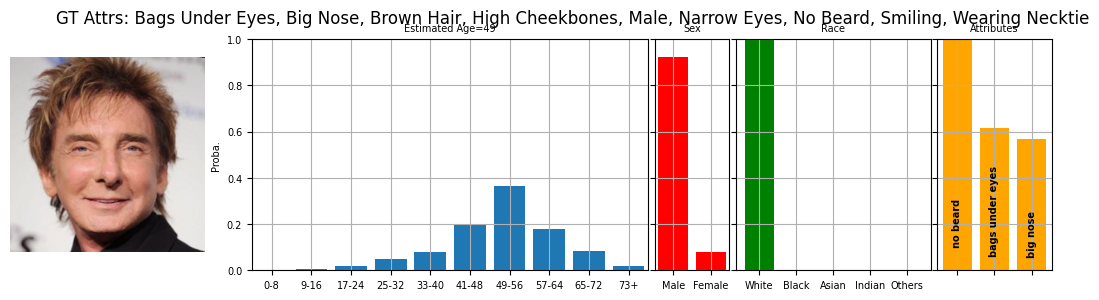

blip2-2.7b(0.3605): barry manilow to perform at the grammys
blip-large(0.2758): a close up of a person with a black shirt and a black jacket
blip2-flan-t5-xl(0.2635): a man with short hair smiling at the camera
git-large-coco(0.2494): ##0 ] is a singer, songwriter, musician, and musician. he is best known for playing the guitar. he is best known for playing the guitar. [ unused0 ], [ unused
blip-base(0.2295): rod vandy, who is the founder of the new york club
vit-gpt2(0.2105): a man with a beard and a tie
vit-swin(0.2066): A man with a beard and a tie.


In [38]:
def draw_attributes(img, res, 
                    img_title=None, 
                    figsize=(15,3),  
                    fontsize=7, 
                    output_file=None, 
                    thresh=0.5, topK=5) :
    from matplotlib import gridspec
    fig = pyplot.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 29)
    ax = pyplot.subplot(gs[0,:5])
    ax.imshow(img)
    ax.axis('off')
    if img_title is not None :
        fig.suptitle(img_title)
    # plot age distribution
    age_proba = res['age_proba']
    age_est = res['age_estimated']
    xs = ['0-8', '9-16', '17-24', '25-32', '33-40', '41-48', '49-56', '57-64', '65-72','73+']
    ys = [age_proba[x] for x in xs]
    ax0 = pyplot.subplot(gs[0,6:16])
    ax0.bar(range(10), ys)
    ax0.set_xticks(range(10))
    ax0.set_xticklabels(xs)
    ax0.tick_params(labelsize=fontsize)
    ax0.set_ylim([0,1])
    ax0.set_xlim([-.5,9.5])
    ax0.grid()
    ax0.set_ylabel('Proba.', fontsize=fontsize)
    ax0.set_title('Estimated Age={:d}'.format(int(age_est)), fontsize=fontsize)
    # plot sex distribution
    sex_proba = res['sex_proba']
    xs = ['male', 'female']
    ys = [sex_proba[x] for x in xs]
    ax1 = pyplot.subplot(gs[0,16:18])
    ax1.bar(range(2), ys, color='r')
    ax1.set_ylim([0,1])
    ax1.set_xticks(range(2))
    ax1.set_xticklabels([x.capitalize() for x in xs] )
    ax1.tick_params(labelsize=fontsize)
    ax1.set_yticklabels([])
    ax1.grid()
    ax1.set_title('Sex', fontsize=fontsize)
    # plot race distribution
    race_proba = res['race_proba']
    xs = ['White', 'Black', 'Asian', 'Indian', 'Others(e.g. Hispanic, Latino, Arabic)']
    ys = [race_proba[x] for x in xs]
    ax2 = pyplot.subplot(gs[0,18:23])
    ax2.bar(range(5), ys, color='g')
    ax2.set_ylim([0,1])
    ax2.set_xticks(range(5))
    ax2.set_xticklabels([ x if 'Others' not in x else 'Others' for x in xs ] )
    ax2.tick_params(labelsize=fontsize)
    #ax2.yaxis.tick_right()
    ax2.set_yticklabels([])
    ax2.grid()
    ax2.set_title('Race', fontsize=fontsize)
    # plot positive attr
    attr_proba = dict(res['attr_proba'])
    if sex_proba['male'] > .5 :
        interested_keys = ['5_o_clock_shadow', 'bags_under_eyes', 
                     'bald', 'big_lips', 'big_nose', 'black_hair', 'blond_hair', 
                     'blurry', 'brown_hair',  'chubby', 'double_chin', 
                     'eyeglasses', 'goatee', 'gray_hair', 'mustache', 'narrow_eyes',
                     'no_beard', 'oval_face', 'pale_skin', 'pointy_nose', 'receding_hairline', 
                     'sideburns', 'wearing_hat']
    else :
        interested_keys = ['arched_eyebrows', 'attractive', 'bags_under_eyes', 
         'bangs', 'big_lips', 'big_nose', 'black_hair', 'blond_hair', 'blurry', 
          'brown_hair', 'bushy_eyebrows', 'chubby', 'double_chin', 'eyeglasses', 
          'gray_hair', 'heavy_makeup', 'high_cheekbones', 
          'narrow_eyes', 'oval_face', 'pale_skin', 'pointy_nose', 
          'receding_hairline', 'rosy_cheeks', 'straight_hair', 
          'wavy_hair', 'wearing_earrings', 'wearing_hat', 'wearing_lipstick', 
          'wearing_necklace', 'wearing_necktie']
    keys = interested_keys
    vals = np.array([attr_proba[k] for k in keys])
    inds = np.argsort(vals)[::-1]
    selected = [ i for i in inds[:17] if vals[i] > thresh ]
    L = len(selected) 
    if (L > 0) :
        L = min(L, topK)
        selected = selected[:L]
        ax3 = pyplot.subplot(gs[0,23:23+L])
        ff = ax3.bar(range(L), vals[selected], color='orange')
        ax3.set_xticks(range(L))
        ax3.set_yticklabels([])
        ax3.set_xticklabels([])
        #ax3.set_xticklabels([keys[s] for s in selected], fontsize=fontsize, rotation=45)
        for r, label in zip(ff, [keys[s] for s in selected]) :
            h = r.get_height()
            ax3.text(r.get_x() + r.get_width() / 2., h/10., label.replace('_',' '), ha="center", va="bottom", color="black", fontsize=fontsize, rotation=90, fontweight="bold")
        ax3.set_ylim([0,1])
        ax3.grid()
        ax3.set_title('Attributes', fontsize=fontsize)
    # save if needed
    if output_file is not None :
        fig.savefig(output_file, bbox_inches='tight')
        print("INFO: save result visualization to", output_file)
    else :
        pyplot.show()
    
# 3. show face image + attributes + captions
def show_img_attrs_captions(sample) :
    # read face_file
    img = Image.open(os.path.join(root_dir, sample['face_file']))
    size = sample['annot_size']
    # read attributes
    true_attrs = ", ".join(json.loads(sample['attributes']))
    pred_attrs = json.load(open(os.path.join(root_dir, sample['attr_file'])))
    captions = json.load(open(os.path.join(root_dir, sample['caption_file'])))

    title, clip_scores = [], []
    for cap, lut in captions.items() :
        model = lut['model']
        score = lut['CLIP_score']
        clip_scores.append(score)
        title.append(f'{model}({score:.4f}): {cap}')
    indices = np.argsort(clip_scores)[::-1]
    title = '\n'.join([title[i] for i in indices])
    draw_attributes(img, pred_attrs, 
                    img_title='GT Attrs: ' + true_attrs, 
                    figsize=(15, 3))
    print(title)


for i in subj2indices[subj][:num_samples] :
    sample= df.iloc[i]
    show_img_attrs_captions(sample)



In [39]:
def compute_cosine_scores(feats) :
    # normalize each row
    norms = np.linalg.norm(feats, axis=1, keepdims=True)
    normalized_feats = feats / norms

    # compute cosine similarity
    similarity = normalized_feats @ normalized_feats.T
    return similarity

feats, imgs = [], []
for i in subj2indices[subj][:num_samples] :
    sample= df.iloc[i]
    feat = json.load(open(os.path.join(root_dir, sample['feat_file'])))
    img = Image.open(os.path.join(root_dir, sample['face_file']))
    feats.append(feat)
    imgs.append(img)

feats = np.row_stack(feats)
simi_scores = compute_cosine_scores(feats)

                     

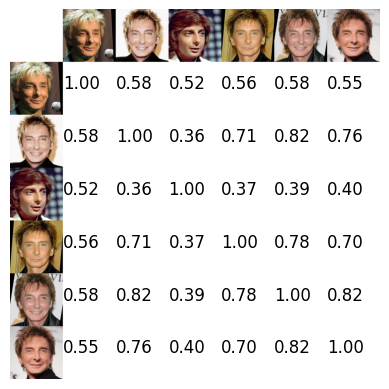

In [40]:
size = 200
blank = np.ones([size,size,3]).astype('uint8') * 255
rows = [np.column_stack([blank] + [t.resize((size,size)) for t in imgs])]
for i, t in enumerate(imgs) :
    rows.append(np.column_stack([t.resize((size,size))] + [blank] * num_samples))
pyplot.imshow(np.row_stack(rows))

for i in range(num_samples) :
    for j in range(num_samples) :
        x = (1+i) * size 
        y = (1+j) * size + size//2
        pyplot.annotate( '{:.2f}'.format(simi_scores[i,j]), (x, y), fontsize=12)
pyplot.axis('off')
pyplot.grid()